In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pd.options.display.max_rows = 200000
pd.options.display.max_columns = 500
pd.set_option('display.float_format', lambda x: '%.4f' %x)

now = dt.datetime.now().strftime('%Y-%m-%d-%H-%M')
result_dir = f'results/{now}/'

def printer(x):
    print(f'{x}\n-------------------')

In [2]:
data = pd.read_csv('model-data/train.csv').set_index('hadm_id')
data_no_scaled = pd.read_csv('model-data/train_no_scaled.csv').set_index('hadm_id')
test = pd.read_csv('model-data/test.csv')
printer('final data')
data.shape
data.sample(5)

final data
-------------------


(18268, 198)

,hcc_cd_135,ft_age,ft_gender,ft_admit_type_elective,ft_admit_type_emergency,ft_admit_type_urgent,ft_race_american_indian_alaska_native,ft_race_american_indian_alaska_native_federally_recognized_tribe,ft_race_asian,ft_race_asian_asian_indian,ft_race_asian_cambodian,ft_race_asian_chinese,ft_race_asian_filipino,ft_race_asian_japanese,ft_race_asian_korean,ft_race_asian_other,ft_race_asian_thai,ft_race_asian_vietnamese,ft_race_black_african,ft_race_black_african_american,ft_race_black_cape_verdean,ft_race_black_haitian,ft_race_caribbean_island,ft_race_hispanic_latino_central_american_(other),ft_race_hispanic_latino_colombian,ft_race_hispanic_latino_cuban,ft_race_hispanic_latino_dominican,ft_race_hispanic_latino_guatemalan,ft_race_hispanic_latino_honduran,ft_race_hispanic_latino_mexican,ft_race_hispanic_latino_puerto_rican,ft_race_hispanic_latino_salvadoran,ft_race_hispanic_or_latino,ft_race_middle_eastern,ft_race_multi_race_ethnicity,ft_race_native_hawaiian_or_other_pacific_islander,ft_race_other,ft_race_portuguese,ft_race_south_american,ft_race_unable_to_obtain,ft_race_white,ft_race_white_brazilian,ft_race_white_eastern_european,ft_race_white_other_european,ft_race_white_russian,ft_race_missing_info,ft_creatinine_increase_within_48,ft_creatinine_increase_from_baseline,ft_baseline_creat_gt_1,ft_baseline_creatinine,ft_avg_creatinine,ft_avg_hematocrit,ft_above_normal_hematocrit,ft_below_normal_hematocrit,ft_way_below_normal_hematocrit,ft_elevated_bp,ft_abnormally_low_bp,ft_hbp_stg_1,ft_hbp_stg_2,ft_hbp_crisis,ft_hbp_stg_2_within_6_hours,ft_hbp_stg_2_within_12_hours,ft_hbp_stg_2_within_24_hours,ft_hbp_stg_2_within_36_hours,ft_hbp_stg_2_within_48_hours,ft_low_blood_ph,ft_low_blood_ph_within_6_hrs,ft_low_blood_ph_within_12_hrs,ft_low_blood_ph_within_24_hrs,ft_low_blood_ph_within_36_hrs,ft_low_blood_ph_within_48_hrs,ft_hcc_cd_19_dbtes_wo_comp,ft_hcc_cd_137_ckd_stg_4,ft_hcc_cd_136_ckd_stg_5,ft_hcc_cd_85_chf,ft_hcc_cd_108_vascular,ft_prior_admission_30,ft_prior_admission_60,ft_prior_admission_90,ft_prior_admission_120,ft_avg_icu_los_within_30,ft_micu_within_30,ft_ccu_within_30,ft_any_nephrotoxin_rx,ft_any_nephrotoxin_rx_within_24,ft_any_nephrotoxin_rx_within_48,ft_any_nephrotoxin_rx_within_72,ft_nephrotoxin_bacitracin_rx,ft_nephrotoxin_bacitracin_rx_within_24,ft_nephrotoxin_bacitracin_rx_within_48,ft_nephrotoxin_bacitracin_rx_within_72,ft_nephrotoxin_vancomycin_rx,ft_nephrotoxin_vancomycin_rx_within_24,ft_nephrotoxin_vancomycin_rx_within_48,ft_nephrotoxin_vancomycin_rx_within_72,ft_nephrotoxin_amphotericin_rx,ft_nephrotoxin_amphotericin_rx_within_24,ft_nephrotoxin_amphotericin_rx_within_48,ft_nephrotoxin_amphotericin_rx_within_72,ft_nephrotoxin_cephalexin_rx,ft_nephrotoxin_cephalexin_rx_within_24,ft_nephrotoxin_cephalexin_rx_within_48,ft_nephrotoxin_cephalexin_rx_within_72,ft_nephrotoxin_tobramycin_rx,ft_nephrotoxin_tobramycin_rx_within_24,ft_nephrotoxin_tobramycin_rx_within_48,ft_nephrotoxin_tobramycin_rx_within_72,ft_nephrotoxin_gentamicin_rx,ft_nephrotoxin_gentamicin_rx_within_24,ft_nephrotoxin_gentamicin_rx_within_48,ft_nephrotoxin_gentamicin_rx_within_72,ft_nephrotoxin_neomycin_rx,ft_nephrotoxin_neomycin_rx_within_24,ft_nephrotoxin_neomycin_rx_within_48,ft_nephrotoxin_neomycin_rx_within_72,ft_nephrotoxin_ciprofloxacin_rx,ft_nephrotoxin_ciprofloxacin_rx_within_24,ft_nephrotoxin_ciprofloxacin_rx_within_48,ft_nephrotoxin_ciprofloxacin_rx_within_72,ft_nephrotoxin_antibiotics_rx,ft_nephrotoxin_antibiotics_rx_within_24,ft_nephrotoxin_antibiotics_rx_within_48,ft_nephrotoxin_antibiotics_rx_within_72,ft_nephrotoxin_lisinopril_rx,ft_nephrotoxin_lisinopril_rx_within_24,ft_nephrotoxin_lisinopril_rx_within_48,ft_nephrotoxin_lisinopril_rx_within_72,ft_nephrotoxin_ramipril_rx,ft_nephrotoxin_ramipril_rx_within_24,ft_nephrotoxin_ramipril_rx_within_48,ft_nephrotoxin_ramipril_rx_within_72,ft_nephrotoxin_metoprolol_rx,ft_nephrotoxin_metoprolol_rx_within_24,ft_nephrotoxin_metoprolol_rx_within_48,ft_nephrotoxin_metoprolol_rx_within_72,ft_nephrotoxin_candes

In [3]:
# all the available features
data.columns.tolist()

['hcc_cd_135',
 'ft_age',
 'ft_gender',
 'ft_admit_type_elective',
 'ft_admit_type_emergency',
 'ft_admit_type_urgent',
 'ft_race_american_indian_alaska_native',
 'ft_race_american_indian_alaska_native_federally_recognized_tribe',
 'ft_race_asian',
 'ft_race_asian_asian_indian',
 'ft_race_asian_cambodian',
 'ft_race_asian_chinese',
 'ft_race_asian_filipino',
 'ft_race_asian_japanese',
 'ft_race_asian_korean',
 'ft_race_asian_other',
 'ft_race_asian_thai',
 'ft_race_asian_vietnamese',
 'ft_race_black_african',
 'ft_race_black_african_american',
 'ft_race_black_cape_verdean',
 'ft_race_black_haitian',
 'ft_race_caribbean_island',
 'ft_race_hispanic_latino_central_american_(other)',
 'ft_race_hispanic_latino_colombian',
 'ft_race_hispanic_latino_cuban',
 'ft_race_hispanic_latino_dominican',
 'ft_race_hispanic_latino_guatemalan',
 'ft_race_hispanic_latino_honduran',
 'ft_race_hispanic_latino_mexican',
 'ft_race_hispanic_latino_puerto_rican',
 'ft_race_hispanic_latino_salvadoran',
 'ft_race

**Feature Selection**
---

We can do feature selection a number of different ways that might be helpful. I will try several of these to help me understand which one is best.
1. domain knowledge (pick the features that meta-analysis suggests would be most relevant)
   - use a correlation matrix on the most important features with heatmap
2. pca with domain knowledge / and also unsupervised
3. selectkbest from scikit learn using unscaled data and chisq test
4. decision tree; use the feature importances to determine which one is most important

**Feature Selection #1: Using Domain Knowledge**
---
We can pick variables used in prior studies and based on our clinical knowledge may be relevant. A [cross sectional meta-analysis]('~/Documents/classes/nyu-1001-intro-to-ds/term-project/resources/aki-paper-bmj.pdf') looks at studies which have range of features 11-48 and included 3-29 of those. We have over 200 and need to pare down our features to the most important. Some of the feautres below should be good predictors of AKI.

In [4]:
lit_features = ['ft_age', 
                'ft_creatinine_increase_within_48',
                'ft_avg_hematocrit',
                'ft_hcc_cd_2_sepsis',
                'ft_avg_icu_los_within_30',
                'ft_baseline_creatinine',
                'ft_gender',
                # 'ft_nephrotoxin_blood_pressure_rx_within_24',
                'ft_nephrotoxin_diuretic_rx_within_24',
                'ft_nephrotoxin_ibuprofen_rx_within_24',
                'ft_low_blood_ph_within_12_hrs',
                'ft_high_potassium',
                # 'ft_prior_admission_90',
                'ft_hcc_cd_19_dbtes_wo_comp',
                'ft_hcc_cd_29_chronic_hepatitis',
                'ft_hcc_cd_85_chf',
                'ft_hcc_cd_136_ckd_stg_5',
                #'ft_hcc_cd_137_ckd_stg_4',
                #'ft_abnormally_low_bp'
               ]

<Figure size 1440x1440 with 0 Axes>

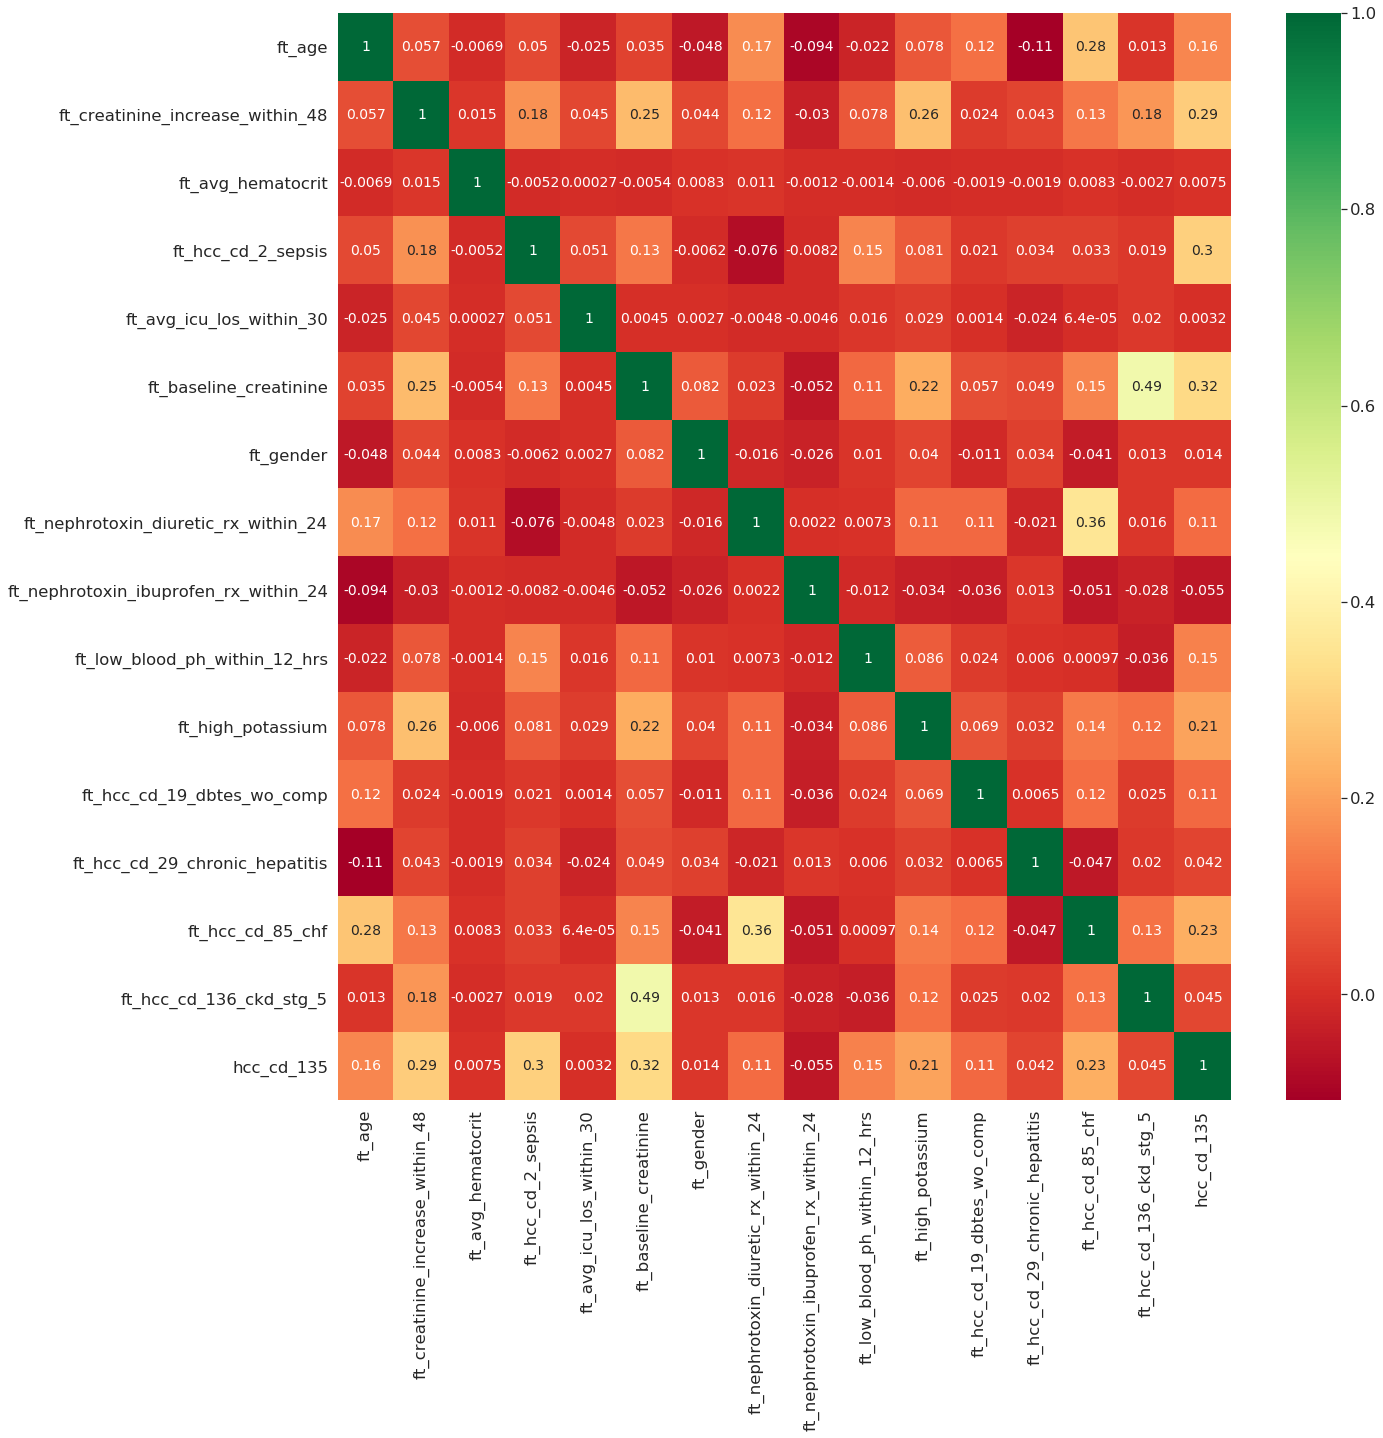

In [5]:
subs = data[lit_features + ['hcc_cd_135']]
corrmat = subs.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn", annot_kws={"size": 14})

In [6]:
lit_feature_importance = corrmat[['hcc_cd_135']]\
.drop('hcc_cd_135')\
.reset_index().rename(columns={'index': 'feature', 'hcc_cd_135': 'importance'})

### **Discussion**
It 

**Feature Selection #2: Using PCA (supervised/unsupervised)**
---

**PCA**
---
> Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting  information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

In [76]:
def pca(n, data, features):
    pca = PCA(n)
    principal_comp = pca.fit_transform(data[features].values)
    principal_df = pd.DataFrame(principal_comp, columns=[f'pc_{i}' for i in range(len(pca.explained_variance_ratio_))])
    feature_explained_variance = pd.DataFrame.from_dict(dict(zip(principal_df.columns.tolist(), 
                                pca.explained_variance_ratio_.tolist())), 
                                orient='index', columns=['variance'])
    return pca, principal_df, feature_explained_variance

def plot_pcs(components, target_variable, pc_a, pc_b):
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel(pc_a,fontsize=14)
    plt.ylabel(pc_b,fontsize=14)
    rcParams['figure.figsize'] = 11.7,8.27
    targets = [0, 1]
    colors = ['g', 'b']
    for target, color in zip(targets,colors):
        idx = target_variable == target
        plt.scatter(components.loc[idx, pc_a], 
                    components.loc[idx, pc_b], c=color, s=6)

    plt.legend(targets,prop={'size': 15})
    
def plot_3d(result, data):
    fig = plt.figure(figsize=(10,10))

    ax = Axes3D(fig) #<-- Note the difference from your original code...
    # ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=result["pc_0"], 
        ys=result["pc_1"], 
        zs=result["pc_2"], 
        c=data["hcc_cd_135"], 
        cmap='tab10',
        s=5
    )
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    ax.set_zlabel('pca-three')
    plt.show()


**PCA using literature features only**

In [77]:
pca_lit, principal_df, feature_explained_variance = pca(5, data, lit_features)
printer('principal components using just lit features')
principal_df.shape, data.shape
principal_df.head()
printer('feature explained variance using just lit features')
feature_explained_variance

principal components using just lit features
-------------------


((18268, 5), (18268, 198))

,pc_0,pc_1,pc_2,pc_3,pc_4
0,3.6395,3.0997,-1.0975,-0.9659,-0.1583
1,1.2966,1.6375,-2.4806,-1.4450,1.0678
2,-1.2757,-0.7803,-0.2660,-1.1813,0.3389
3,-1.0846,0.9372,-0.4471,0.3725,-0.4865
4,-1.4398,-0.7204,-0.2438,-1.0779,0.3694


feature explained variance using just lit features
-------------------


,variance
pc_0,0.1383
pc_1,0.1001
pc_2,0.0787
pc_3,0.0704
pc_4,0.0686


<Figure size 842.4x595.44 with 0 Axes>

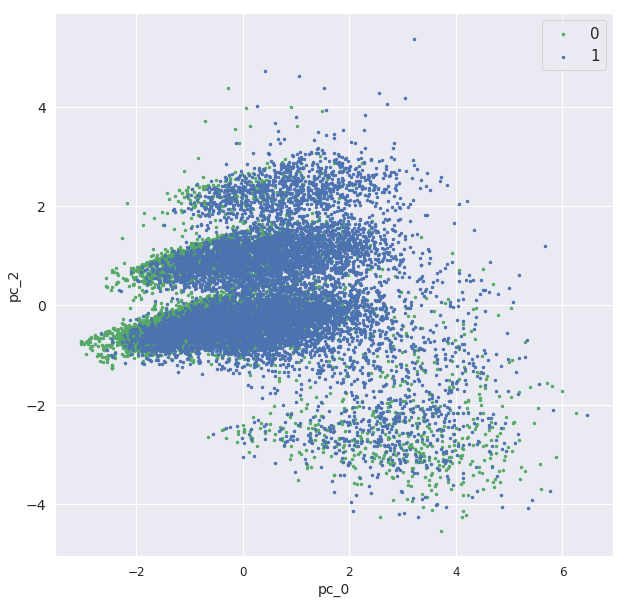

In [78]:
pca_supervised_data = principal_df.copy(deep=True)
plot_pcs(principal_df, data['hcc_cd_135'].reset_index(drop=True), 'pc_0', 'pc_2')

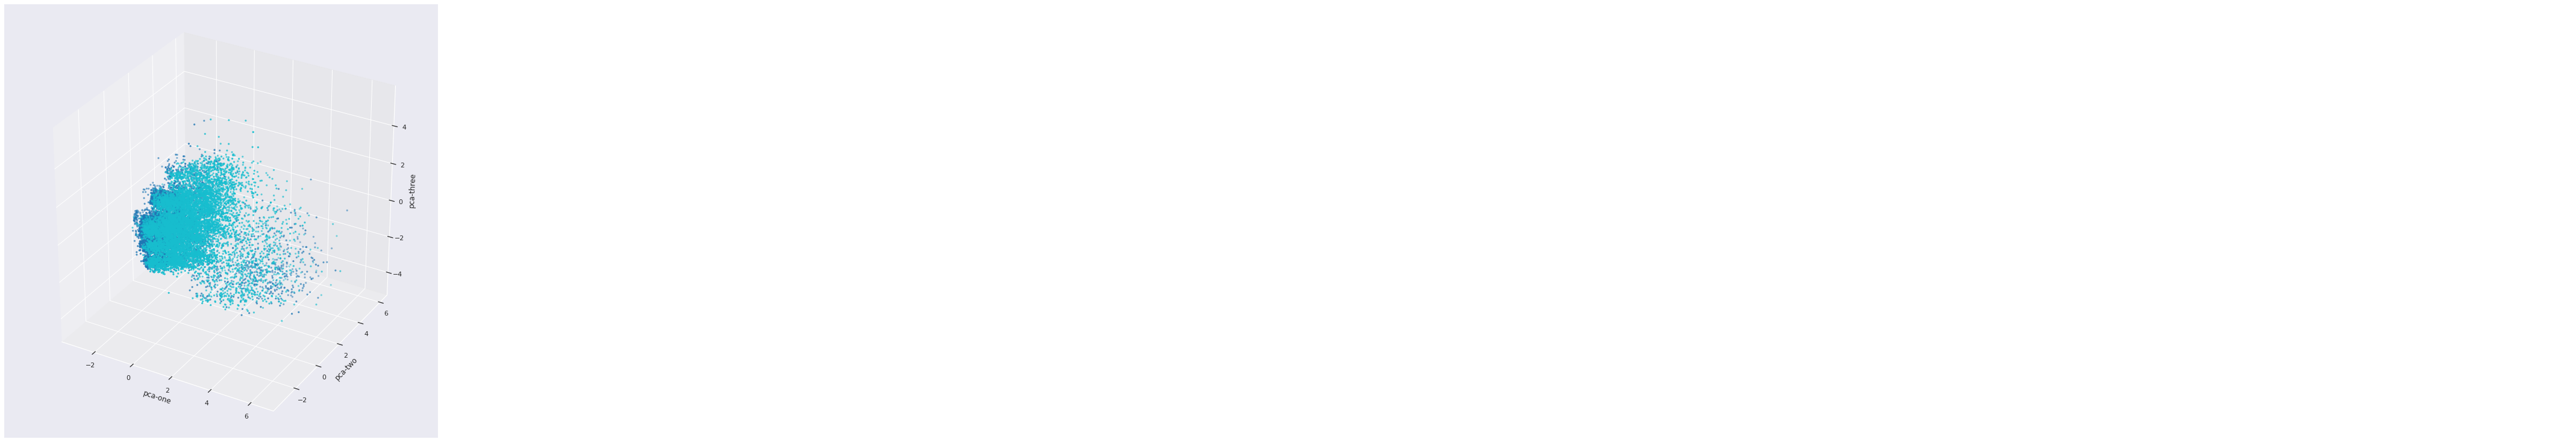

In [79]:
plot_3d(principal_df, data)

**PCA using all the features in the dataset**

In [80]:
all_features = [x for x in data if 'ft_' in x]
pca_all, principal_df, feature_explained_variance = pca(5, data, all_features)
printer('principal components using all features')
principal_df.shape, data.shape
principal_df.head()
printer('feature explained variance using all features')
feature_explained_variance

principal components using all features
-------------------


((18268, 5), (18268, 198))

,pc_0,pc_1,pc_2,pc_3,pc_4
0,-0.5868,8.4756,-7.1501,1.4043,-1.8769
1,3.7785,2.1641,-2.8026,0.5418,-0.6606
2,-2.1514,2.0240,-1.5503,0.3804,-0.4616
3,-6.1901,0.5931,1.7547,-1.2236,1.6061
4,-2.2142,-0.6582,0.3084,-0.5903,0.6626


feature explained variance using all features
-------------------


,variance
pc_0,0.0581
pc_1,0.0436
pc_2,0.0374
pc_3,0.0341
pc_4,0.0331


<Figure size 842.4x595.44 with 0 Axes>

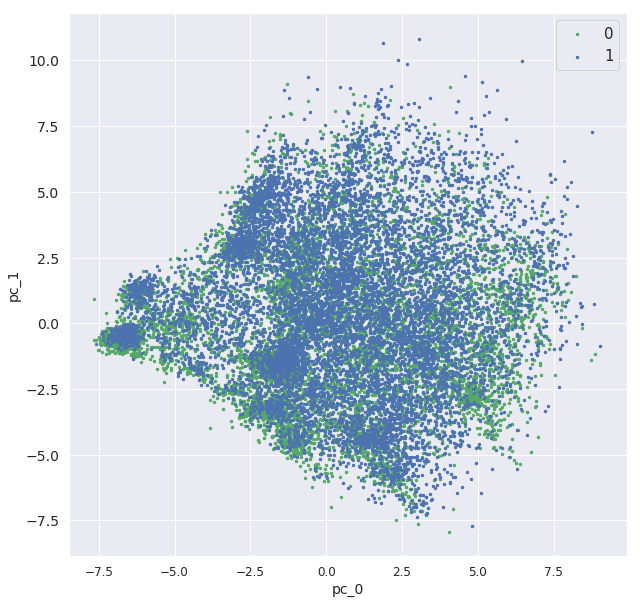

In [81]:
pca_unsupervised_data = principal_df.copy(deep=True)
plot_pcs(principal_df, data['hcc_cd_135'].reset_index(drop=True), 'pc_0', 'pc_1')

In [83]:
explained_variances = []

for i in range(5,10):
    _, _, variance = pca(i, data, all_features)
    explained_variances.append(variance.T)
    
explained_variances = pd.concat(explained_variances, ignore_index=True, sort=False)
explained_variances['N'] = range(5,10)
explained_variances

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,N
0,0.0581,0.0436,0.0374,0.0341,0.0331,nan,nan,nan,nan,5
1,0.0581,0.0436,0.0374,0.0341,0.0331,0.0246,nan,nan,nan,6
2,0.0581,0.0436,0.0374,0.0341,0.0331,0.0246,0.0238,nan,nan,7
3,0.0581,0.0436,0.0374,0.0341,0.0331,0.0246,0.0238,0.0233,nan,8
4,0.0581,0.0436,0.0374,0.0341,0.0331,0.0246,0.0238,0.0233,0.0201,9


### **Discussion**
- PCA doesn't seem to be successful. Either we don't have enough information in our feature engineering set to sufficiently predict AKI or we are missing something.
- PCA also doesn't seem to totally work on the "one-hot" encoded variables that we have in this dataset. We may consider doing MCA instead.
- Also number of components provided to the PCA doesn't change the explained ratio of each feature. As we add components, we add the percentage of variance in the original graph explained by that variable.

**Feature Selection #3: Select K Best**
---
For this it is important to use **unscaled** data and **drop** any fields which might have negative values.

In [22]:
def score_features(data, label, features=None, n=15):
    if not features:
        features = data.drop(label, axis=1).columns.tolist()
        
    best_features = SelectKBest(score_func=chi2, k=n) # ok for binary data
    X, y = data[features].values, data[label].values
    fit = best_features.fit(X,y)
    
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(features)

    featureScores = pd.concat([df_columns, df_scores],axis=1)
    featureScores.columns = ['feature','importance'] 
    return featureScores.nlargest(n, 'importance')

In [23]:
select_k_best = score_features(data_no_scaled.drop(['ft_avg_creatinine', 'ft_baseline_creatinine'], axis=1), 'hcc_cd_135')
select_k_best

,feature,importance
48,ft_avg_hematocrit,15628.4101
47,ft_baseline_creat_gt_1,2027.4427
0,ft_age,1818.7261
190,ft_hcc_cd_2_sepsis,1327.5930
45,ft_creatinine_increase_within_48,1204.7484
46,ft_creatinine_increase_from_baseline,723.0573
2,ft_admit_type_elective,649.5675
71,ft_hcc_cd_85_chf,607.1758
118,ft_nephrotoxin_antibiotics_rx_within_48,533.0030
117,ft_nephrotoxin_antibiotics_rx_within_24,516.5571


**Feature Selection #3: Decision Tree**
---
Use a decision tree to identify the most important features. Use the default settings on the tree.

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

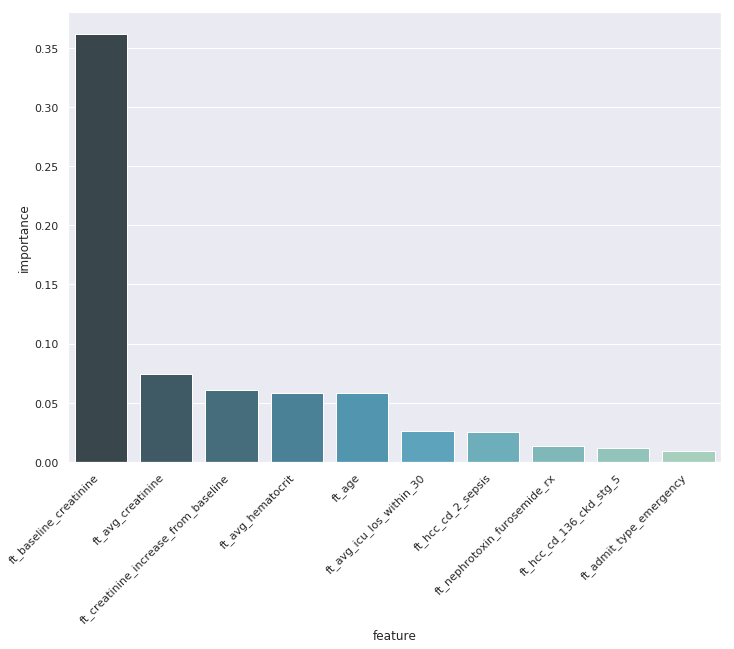

In [24]:
# fit the classifier
unrelated_features = [x for x in data if ('creat' not in x) and ('ft_' in x)]

clf = DecisionTreeClassifier(criterion='gini')
X = data[all_features].values
y = data.hcc_cd_135
clf.fit(X,y)

# figure size in inches
def plot_feature_importance(classifier, features):
    feature_importance = pd.DataFrame({'feature': features, 
                                       'importance': classifier.feature_importances_})\
                            .sort_values('importance')\
                            .nlargest(10, 'importance')
    colors = sns.color_palette("GnBu_d", n_colors=len(feature_importance))
    rcParams['figure.figsize'] = 11.7,8.27
    sns.set(font_scale=1)
    chart = sns.barplot(x='feature', y="importance", data=feature_importance, palette=colors)
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='light'
    )
    return feature_importance

decision_feature_importance = plot_feature_importance(clf, all_features)

**Selected Features**
---

In [94]:
feature_set = [
    {'selection_type': 'default',
     'data': data,
     'features': [x for x in data if 'ft_' in x]},
    {'selection_type': 'literature',
     'data': data,
     'features': lit_feature_importance.feature.values.tolist()},
    {'selection_type': 'pca-supervised',
     'data': pd.concat([pca_supervised_data, data[['hcc_cd_135']].reset_index(drop=True)], axis=1),
     'features': pca_supervised_data.columns},
    {'selection_type': 'pca-unsupervised',
     'data': pd.concat([pca_unsupervised_data, data[['hcc_cd_135']].reset_index(drop=True)], axis=1),
     'features': pca_unsupervised_data.columns},
    {'selection_type': 'select-k-best',
     'data': data,
     'features': select_k_best.feature.values.tolist()},
    {'selection_type': 'decision-tree',
     'data': data,
     'features': decision_feature_importance.feature.values.tolist()},
]

In [95]:
lp = []
for v in feature_set:
    selection, features = v['selection_type'], v['features']
    if 'pca' in selection:
        continue
    res = pd.DataFrame.from_dict({selection: sorted(features)}, orient='index')\
                      .T\
                      .set_index(selection)
    res[selection] = 1
    lp.append(res)
import functools
lp = functools.reduce(lambda x,y: x.join(y, how='outer'), lp)
lp['used'] = lp.sum(axis=1)
lp.sort_values('used', ascending=False).fillna(' ').head(20)

,default,literature,select-k-best,decision-tree,used
ft_age,1,1.0000,1.0000,1.0000,4.0000
ft_hcc_cd_2_sepsis,1,1.0000,1.0000,1.0000,4.0000
ft_avg_hematocrit,1,1.0000,1.0000,1.0000,4.0000
ft_creatinine_increase_from_baseline,1,,1.0000,1.0000,3.0000
ft_avg_icu_los_within_30,1,1.0000,,1.0000,3.0000
ft_high_potassium,1,1.0000,1.0000,,3.0000
ft_hcc_cd_85_chf,1,1.0000,1.0000,,3.0000
ft_baseline_creatinine,1,1.0000,,1.0000,3.0000
ft_creatinine_increase_within_48,1,1.0000,1.0000,,3.0000
ft_hcc_cd_136_ckd_stg_5,1,1.0000,,1.0000,3.0000


**Logistic Regression**
---

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def logistic_regression(data, test, features, selection):
    printer('\n| ' + selection + ' |')
    lreg = LogisticRegression(solver='lbfgs')
    features = [x for x in features if x in test]

    lreg.fit(data[features].values, data['hcc_cd_135'].values)

    printer('\nlogistic regression internal score')
    print(lreg.score(test[features].values, test['hcc_cd_135'].values))

    # printer('\ncorr with final score')
    test_with_res = test.copy(deep=True)
    test_with_res['y_pred'] = lreg.predict(test[features])
    # print(test_with_res[['hcc_cd_135', 'y_pred']].corr())
    
    printer('\n actual crosstab')
    print(test.shape)
    print(pd.crosstab(test_with_res.hcc_cd_135, test_with_res.y_pred, normalize=True))

    printer('\nauc metrics')
    y_score = lreg.decision_function(test[features])
    fpr, tpr, _ = metrics.roc_curve(test['hcc_cd_135'].values, y_score)
    auc = metrics.auc(fpr, tpr)
    print(auc)
    
    return [fpr, tpr, auc, selection]

In [155]:
def plot_roc(models):      
    plt.figure(figsize=(10,6))
    colors = ['blue', 'skyblue', 'green', 'teal', 'pink', 'magenta', 'purple']
    for c, m in zip(colors, models):
        fpr, tpr, auc, name = m
        plt.plot(fpr, tpr, color=c, lw=1, label=f'{name} AUC:{round(auc,4)}') 
        plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
        
    plt.xlim([0.0, 1.02])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC Curve with difference models')
    plt.legend(loc="lower right")
    plt.show()

In [136]:
models = []
for i in feature_set:
    selection, data, features = i['selection_type'], i['data'], i['features']
    if 'pca-supervised' in selection:
        test_sub = pd.DataFrame(pca_lit.transform(test[lit_features]))
        test_sub.columns = [f'pc_{i}' for i in range(0, 5)]
        test_sub = pd.concat([test_sub, test[['hcc_cd_135']]], axis=1)
    elif 'pca-unsupervised' in selection:
        continue
        test_sub = pd.DataFrame(pca_all.transform(test[lit_features]))
        test_sub.columns = [f'pc_{i}' for i in range(0, 5)]
        # test_sub,_ = pca(5, test, [x for x in test if 'ft_' in x])
        test_sub = pd.concat([test_sub, test[['hcc_cd_135']]], axis=1)
    else:
        test_sub = test.copy(deep=True)
        
    res = logistic_regression(data, test_sub, features, selection)
    models.append(res)
    print('\n\n')


| default |
-------------------


/Users/lpanda/miniconda3/envs/ds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



logistic regression internal score
-------------------
0.7968476357267951

 actual crosstab
-------------------
(4568, 196)
y_pred          0      1
hcc_cd_135              
0          0.3930 0.1127
1          0.0904 0.4039

auc metrics
-------------------
0.8749329943749784




| literature |
-------------------

logistic regression internal score
-------------------
0.7475919439579685

 actual crosstab
-------------------
(4568, 196)
y_pred          0      1
hcc_cd_135              
0          0.3973 0.1084
1          0.1440 0.3503

auc metrics
-------------------
0.8152280108435999




| pca-supervised |
-------------------

logistic regression internal score
-------------------
0.7204465849387041

 actual crosstab
-------------------
(4568, 6)
y_pred          0      1
hcc_cd_135              
0          0.3794 0.1263
1          0.1532 0.3411

auc metrics
-------------------
0.7806113136936875




| select-k-best |
-------------------

logistic regression internal score
-----------

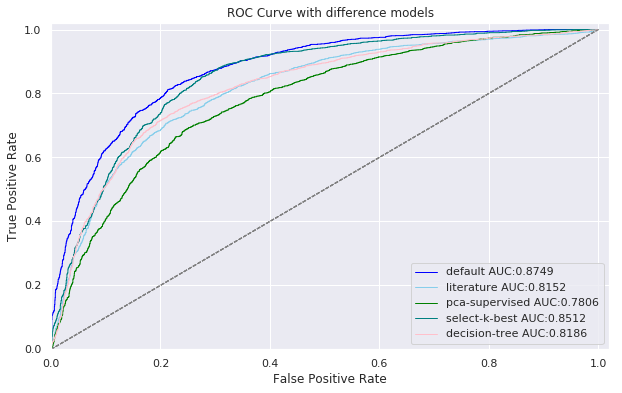

In [137]:
plot_roc(models)

In [164]:
pd.DataFrame.from_dict({i[3]:i[2] for i in models}, orient='index', columns=['auc']).sort_values('auc', ascending=False)

,auc
default,0.8749
select-k-best,0.8512
decision-tree,0.8186
literature,0.8152
pca-supervised,0.7806


**Discussion**

The default model looks to be potentially overfitted? Select K Best found the next best feature set.

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear', 'lbfgs']},
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(10,101,10)),
     'classifier__max_features' : list(range(6,15,2))}
]

clf = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  3.0min finished



auc metrics
-------------------
0.8504470876038636


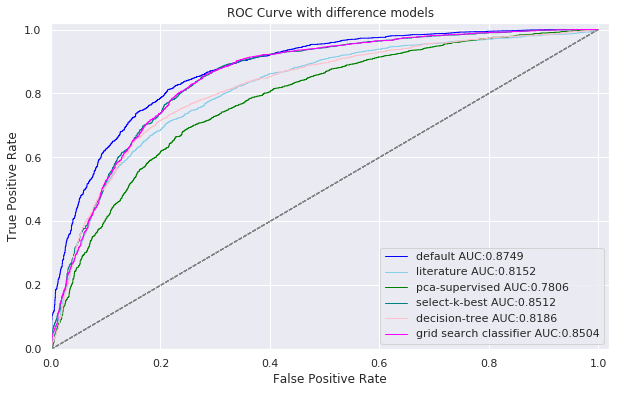

In [159]:
# Fit on data select k best feature set
lp = feature_set[4]
best_clf = clf.fit(lp['data'][lp['features']], lp['data']['hcc_cd_135'])

printer('\nauc metrics')
y_score = best_clf.decision_function(test[lp['features']])
fpr, tpr, _ = metrics.roc_curve(test['hcc_cd_135'].values, y_score)
auc = metrics.auc(fpr, tpr)
print(auc)

models_with_grid = models + [[fpr, tpr, auc, 'grid search classifier']]
plot_roc(models_with_grid)

In [165]:
pd.DataFrame.from_dict({i[3]:i[2] for i in models_with_grid}, orient='index', columns=['auc']).sort_values('auc', ascending=False)

,auc
default,0.8749
select-k-best,0.8512
grid search classifier,0.8504
decision-tree,0.8186
literature,0.8152
pca-supervised,0.7806
